<a href="https://colab.research.google.com/github/johnhallman/ctsb/blob/add_colab_notebooks/notebooks/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/johnhallman/ctsb.git

In [3]:
!pip install jaxlib

     |████████████████████████████████| 23.3MB 41.8MB/s 


# The Problem class
The Problem class is the abstraction used to implement control and time series tasks. CTSB comes pre-loaded with several classical problems (both simulated and real world data) such as ARMA time series or linear dynamical systems. Below we demonstrate how to initialize a problem and step through the simulated time series generated by an ARMA. The initialize() method returns the initial observation. We can also query the hidden state of the system.


info: (DeviceArray([-0.98709023, -2.94246697,  0.12482278], dtype=float32), DeviceArray([0.10366804, 0.3302322 , 0.71433598], dtype=float32))


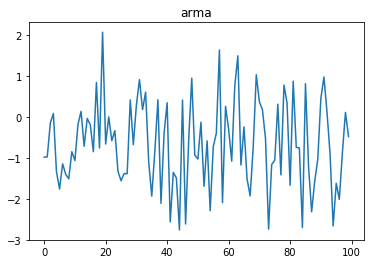

In [6]:
import ctsb
from ctsb.problems.control.arma import ARMA
import jax.numpy as np
import matplotlib.pyplot as plt

T = 100
p, q = 3, 3
problem = ARMA()
problem.initialize(p,q)
test_output = []
for t in range(T):
    test_output.append(problem.step())

info = problem.hidden()
print("info: " + str(info))

plt.plot(test_output)
plt.title("arma")
plt.show(block=False)


The help() method provides more info about the API of a certain Problem class.

In [0]:
problem.help()

# The Model Class
The Model class is the abstraction used to implement models/predictors for the problems. CTSB is designed so that the Model and Problem classes can be combined in a modular fashion. Roughly speaking, the goal of CTSB is to be able to test an arbitrary model on an arbitrary problem, at least when it makes sense to do so. For example, below we show how to combine a basic last-value model (a predictor that just outputs the previous observation) for time series on the ARMA problem.

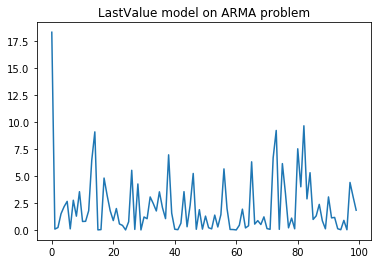

In [11]:
import ctsb
import jax.numpy as np
import matplotlib.pyplot as plt

T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
cur_x = problem.initialize(p, q)
model = ctsb.model("LastValue")
model.initialize()
loss = lambda y_true, y_pred: (y_true - y_pred)**2

results = []
for i in range(T):
    cur_y_pred = model.predict(cur_x)
    cur_y_true = problem.step()
    cur_loss = loss(cur_y_true, cur_y_pred)
    results.append(cur_loss)
    model.update(cur_loss)
    cur_x = cur_y_true

plt.plot(results)
plt.title("LastValue model on ARMA problem")
plt.show(block=False)


# The Problem and Model Registry
Each of the Problem and Model classes included in CTSB are inserted into a global registry, which is dict from a unique string to the Problem/Model class corresponding to the string. The registry supports versioning, so that multiple versions of a certain Problem/Model can be referenced. For example, the id "ARMA-v0" is the registry id for version 0 of the ARMA problem. The previous example shows how to create instances of problem and model via the corresponding registry ids. A comprehensive list of all Problem and Model ids can be printed by printing out the keys of the global registries: problem_registry and model_registry, as demonstrated below.

In [16]:
print(ctsb.problem_registry.keys())
print(ctsb.model_registry.keys())

dict_keys(['Random-v0', 'ARMA-v0', 'LDS-v0', 'RNN-v0', 'LSTM-v0', 'SP500-v0', 'UCIIndoor-v0', 'Crypto-v0'])
dict_keys(['LastValue', 'Linear', 'PredictZero', 'KalmanFilter'])


# The Experiment Class
The EXperiment class should be thought of as a sort of engine that allows the automated combination of various models against various problems. The initialize method supports two types of operation: single problem experiments and multi-problem experiments. A single problem experiment is defined by specifying: a loss function, a single Problem identifed by a unique string in the Problem registry, a dict of problem parameters, and a list of Models identified by unique strings in the Model Registry. We demonstrate how to create a single Problem experiment below.

  1%|          | 1/100 [00:00<00:17,  5.68it/s]

running experiment: <LastValue Model> on <ARMA Problem>


  1%|          | 1/100 [00:00<00:10,  9.20it/s]

running experiment: <PredictZero Model> on <ARMA Problem>


100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


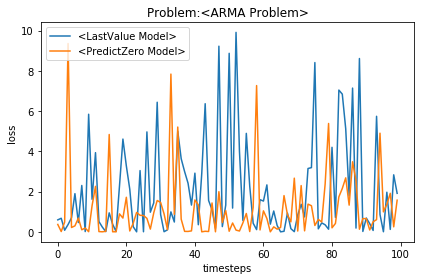

In [9]:
import ctsb
from ctsb.problems.time_series import Crypto
from ctsb.problems.control.arma import ARMA
from ctsb.models.time_series.last_value import LastValue
from ctsb.models.time_series.predict_zero import PredictZero
from ctsb.utils.experiment import Experiment
import jax.numpy as np
import matplotlib.pyplot as plt

def test_single_problem_experiment_intialize(steps=100):
    exp = Experiment()
    MSE = lambda y_true, y_pred: (y_true - y_pred)**2
    exp.initialize(MSE, problem_id="ARMA-v0", problem_params={'p': 3, 'q':3}, model_id_list=['LastValue', 'PredictZero'])
    exp.run_all_experiments(steps)
    exp.plot_all_problem_results()

test_single_problem_experiment_intialize()

# Random Seeding
